# Import Libraries

In [2]:
# General Import
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import PIL
import os
import cv2

# For modelling
import tensorflow as tf
import keras.callbacks
from tensorflow import keras
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical, plot_model
from keras.applications.vgg16 import VGG16

#For layering
from keras import layers, models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

# For processing
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.utils import shuffle
from skimage.io import imread, imshow
from tqdm import tqdm

# Evaluation
from sklearn.metrics import classification_report

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

print(tf.__version__)

Default GPU Device:/device:GPU:0
2.8.2


In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# navigasi ke home folder
% cd /content/drive/MyDrive/Hacktiv8/final_project/

/content/drive/MyDrive/Hacktiv8/final_project


### *Downloading Data from Kaggle*

In [6]:
# # Make a directory named `.kaggle` 
# !mkdir ~/.kaggle

# ## Copy the kaggle.json into this new directory 
# !cp kaggle.json ~/.kaggle/

# ## Change permission for this directory : 
# !chmod 600 ~/.kaggle/kaggle.json

# #%%time 
# # Download Dataset
# # Source dataset : https://www.kaggle.com/datasets/puneet6060/intel-image-classification

# !kaggle datasets download puneet6060/intel-image-classification

# # Every dataset that downloaded from Kaggle, is in format `.zip`. So, we must unzip it before we can using the dataset.

# !unzip ./intel-image-classification.zip

# Explore the Dataset

This Data contains around 25k images of size 150x150 distributed under 5 categories.

```py
{'buildings' -> 0,
'forest' -> 1,
'mountain' -> 2,
'sea' -> 3,
'street' -> 4}
```

The Train, Test and Prediction data is separated in each zip files. There are around 11k images in Train, 3k in Test and 7k in Prediction.

In [7]:
train_folder=r'seg_train/seg_train/'
test_folder=r'seg_test/seg_test/'
pred_folder=r'seg_pred/seg_pred/'

In [8]:
import pathlib
data_dir = pathlib.Path(train_folder)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

11630


There are 11630 total images for training. Let's have a look on `building class` in train segment.

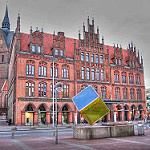

In [9]:
buildings = list(data_dir.glob('buildings/*'))
PIL.Image.open(str(buildings[0]))

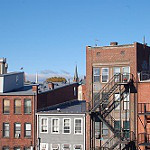

In [10]:
PIL.Image.open(str(buildings[1]))

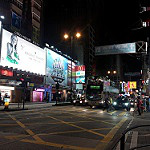

In [11]:
street = list(data_dir.glob('street/*'))
PIL.Image.open(str(street[0]))

## *Label and Load the Dataset*

In [12]:
# assign class labels
class_names = ['buildings','forest','mountain','sea','street']
class_labels = {class_name:i for i, class_name in enumerate(class_names)}
print(class_labels)

number_classes = len(class_names)

IMAGE_SIZE = (150,150)

{'buildings': 0, 'forest': 1, 'mountain': 2, 'sea': 3, 'street': 4}


In [13]:
# usecase of os.listdir and os.path.join functions
for folder in os.listdir(train_folder):
    files_path = []
    for file in os.listdir(os.path.join(train_folder,folder)):
        files_path.append(file)
    print(len(files_path))

2191
2271
2512
2274
2382


In [14]:
# define load_dataset function to load dataset with labels
def load_dataset():
    # create list of datasets
    datasets = [train_folder, test_folder]
    output = []
    
    for dataset in datasets:
        
        images1 = []
        labels1 = []
        print(f"loading {dataset}")
        
        for folder in os.listdir(dataset):
            # assign labels to each folder images
            label = class_labels[folder]
            for file in tqdm(os.listdir(os.path.join(dataset,folder))):
                image_path = os.path.join(os.path.join(dataset, folder), file)
                # read the image files stored in image_path
                image_file = cv2.imread(image_path)
                image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
                image_file = cv2.resize(image_file, IMAGE_SIZE)
                
                images1.append(image_file)
                labels1.append(label)
                
        # convert the images and labels list to numpy array
        images1 = np.array(images1, dtype = 'float32')
        labels1 = np.array(labels1, dtype = 'int32')
        
        output.append((images1, labels1))
        print("Images file have been loaded")
                
    return output 

In [15]:
# load the data using above functions
((train_images, train_labels), (test_images, test_labels)) = load_dataset()

loading seg_train/seg_train/


100%|██████████| 2382/2382 [00:06<00:00, 358.03it/s]


Images file have been loaded
loading seg_test/seg_test/


100%|██████████| 501/501 [00:01<00:00, 428.92it/s]


Images file have been loaded


In [16]:
print("train dataset size")
len(train_images), len(train_labels)

train dataset size


(11630, 11630)

In [17]:
print("test dataset size")
len(test_images), len(test_labels)

test dataset size


(2447, 2447)

# Preprocess & Explore Image Datasets

In [18]:
# shape of image dataset is 4D tensors
train_images.shape, test_images.shape

((11630, 150, 150, 3), (2447, 150, 150, 3))

In [19]:
# shuffle the train and test datasets
(train_images, train_labels) = shuffle(train_images, train_labels, random_state = 0)
(test_images, test_labels) = shuffle(test_images, test_labels, random_state = 0)

In [20]:
# # keeping 6000 data instances for training and testing our model
# train_images = train_images[:6000]
# train_labels = train_labels[:6000]

# test_images = test_images[:1400]
# test_labels = test_labels[:1400]

In [21]:
# normalize the images dataset
train_images_norm = train_images/255.0
test_images_norm = test_images/255.0

In [22]:
# let's see the proportion of classes in train and test dataset
def proportion_labels(labels, dataset):
    series = pd.DataFrame(labels).reset_index()
    series.rename(columns = {0:'labels'}, inplace=True)
    final_s = series.groupby('labels').count().reset_index()                                          
    ticks1= [key for key in class_labels.keys()]
    
    # plot the pie chart and bar graph of labels
    plt.figure(figsize=(15,6))
    
    plt.subplot(121)
    plt.bar(np.array(final_s['labels']), np.array(final_s['index']))
    plt.xticks(ticks=np.array(final_s['labels']), labels=ticks1, fontsize=12, fontweight='bold')
    plt.yticks(fontsize=12, fontweight='bold')
    plt.grid(visible=True)
    plt.title("Number of images per class", size=14, weight='bold')
    
    plt.subplot(122)
    plt.pie(final_s['index'].ravel(),
            labels=ticks1,
            autopct='%1.2f%%',
            textprops={'fontweight':'bold'}
           )
    plt.title("proportion of classes", size=14, weight='bold')
    
    plt.suptitle(f"Proportion of {dataset} data", size=20, weight='bold')
    plt.show()
    
    return final_s

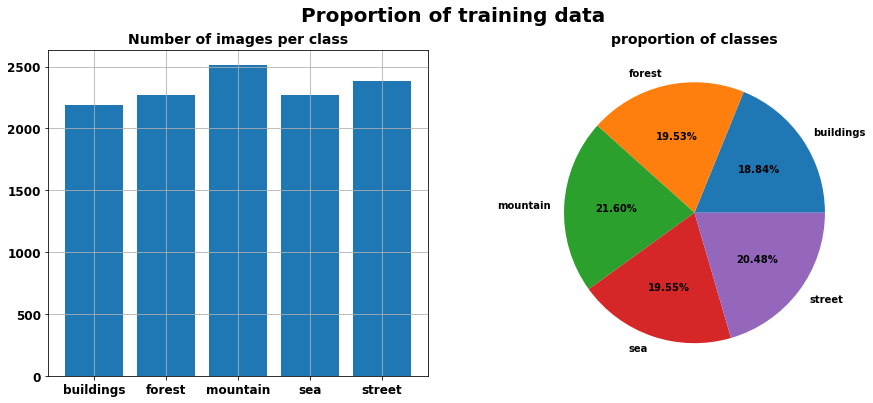

In [23]:
# Proportion of training data
train_prop = proportion_labels(train_labels, "training")

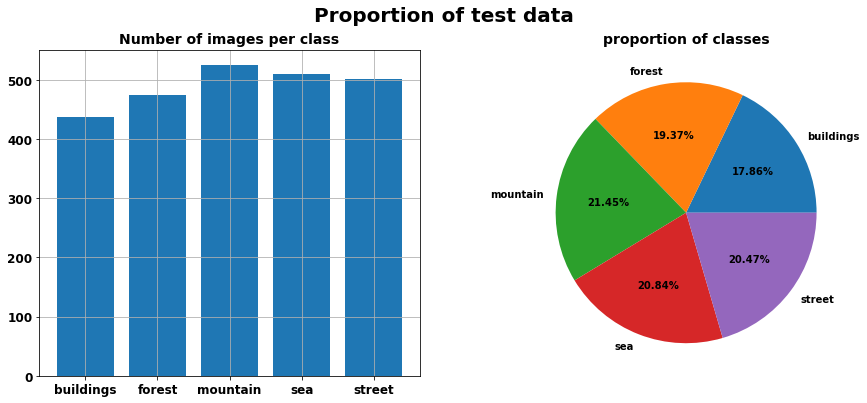

In [24]:
# Proportion of training data
test_prop = proportion_labels(test_labels, "test")

Observation:

Our both `training` and `test` datasets are more or less equally distributed as we shuffled the dataset after loading and labeling.

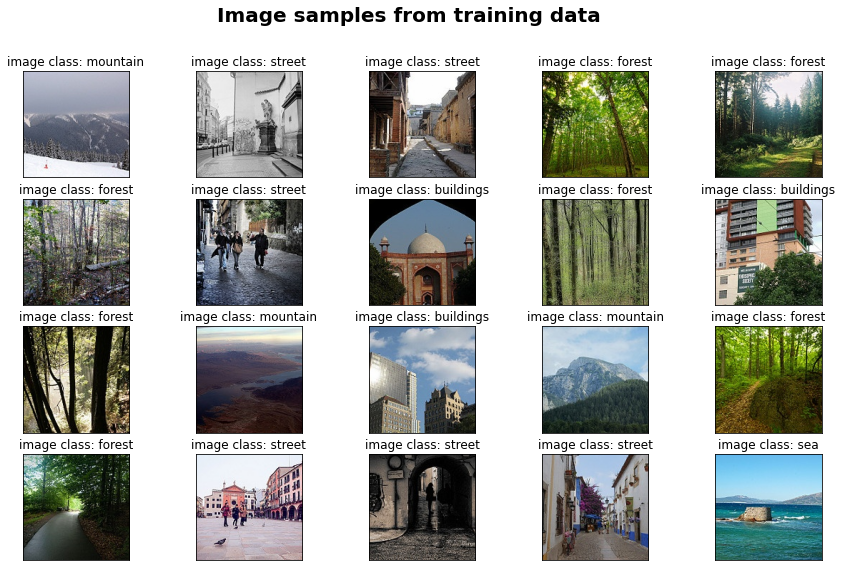

In [25]:
## plot 3*5 visualization of images
plt.figure(figsize=(15,9))
for idx, label in enumerate(train_labels[:20]):
    plt.subplot(4,5, idx+1)
    plt.imshow(train_images_norm[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'image class: {class_names[label]}')   
    
plt.suptitle(f'Image samples from training data', size=20, weight='bold')
plt.show()

# Model Defining

In [26]:
# model architecture of first keras model
model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(number_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

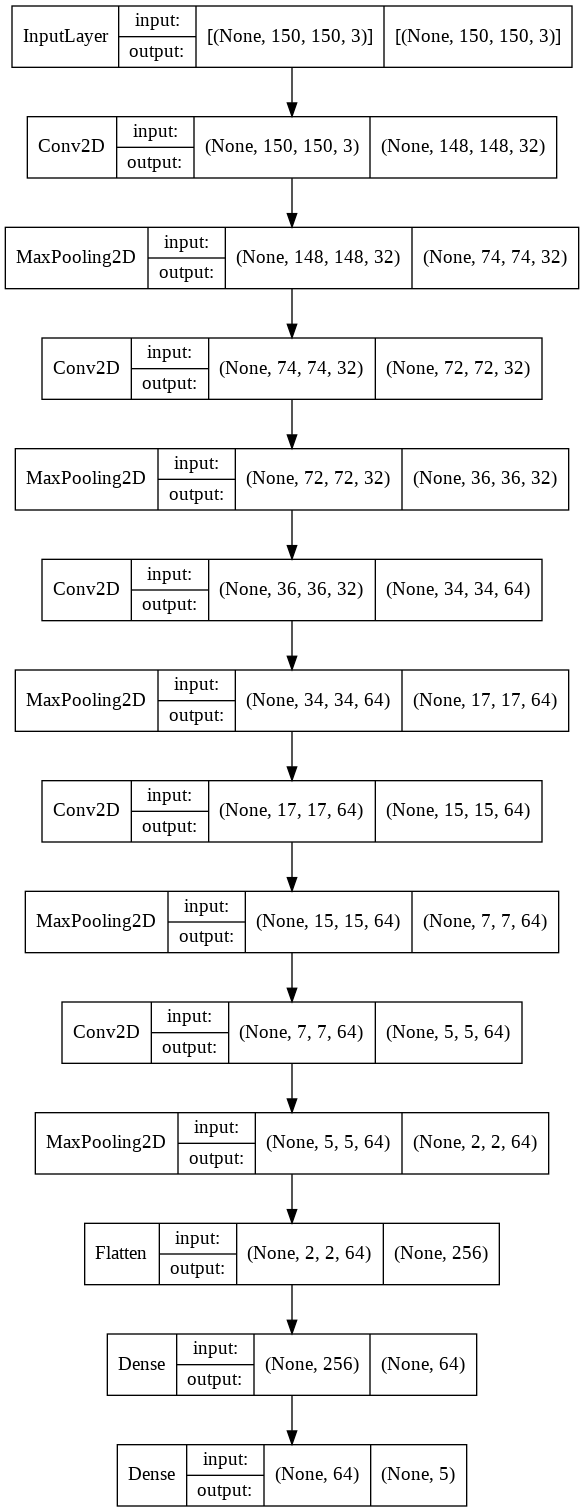

In [27]:
# plot the model algorithm
plot_model(model, show_shapes = True, show_layer_names = False)

# Model Training

In [28]:
# convert labels to categorical 
train_labels_cat = to_categorical(train_labels)
test_labels_cat = to_categorical(test_labels)

# compile the model with 'adam' optimizer
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy']
             )

# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath = 'bestvalue', 
                               verbose = 0, 
                               save_best_only = True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_images_norm, 
                    train_labels_cat, 
                    batch_size = 128, 
                    epochs = 15, 
                    validation_data = (test_images_norm, test_labels_cat),
                    callbacks = callback_list)

# evalute the model
test_loss, test_acc = model.evaluate(test_images_norm, test_labels_cat, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

Epoch 1/15
91/91 [==============================] - 14s 109ms/step - loss: 1.1262 - accuracy: 0.5090 - val_loss: 0.9104 - val_accuracy: 0.6338
Epoch 2/15
91/91 [==============================] - 8s 88ms/step - loss: 0.8131 - accuracy: 0.6616 - val_loss: 0.7726 - val_accuracy: 0.6927
Epoch 3/15
91/91 [==============================] - 8s 88ms/step - loss: 0.7019 - accuracy: 0.7182 - val_loss: 0.6000 - val_accuracy: 0.7716
Epoch 4/15
91/91 [==============================] - 8s 89ms/step - loss: 0.5997 - accuracy: 0.7700 - val_loss: 0.5924 - val_accuracy: 0.7626
Epoch 5/15
91/91 [==============================] - 8s 91ms/step - loss: 0.5418 - accuracy: 0.7915 - val_loss: 0.5183 - val_accuracy: 0.8124
Epoch 6/15
91/91 [==============================] - 8s 90ms/step - loss: 0.4966 - accuracy: 0.8110 - val_loss: 0.4833 - val_accuracy: 0.8308
Epoch 7/15
91/91 [==============================] - 7s 77ms/step - loss: 0.4445 - accuracy: 0.8327 - val_loss: 0.5039 - val_accuracy: 0.8120
Epoch 8/15


### *Plot the Loss and Accuracy Curves*

In [29]:
# Defining accuracy and loss plot funtion
def plot_loss_accuracy(history, len_epochs):
  epochs = len_epochs
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(18, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

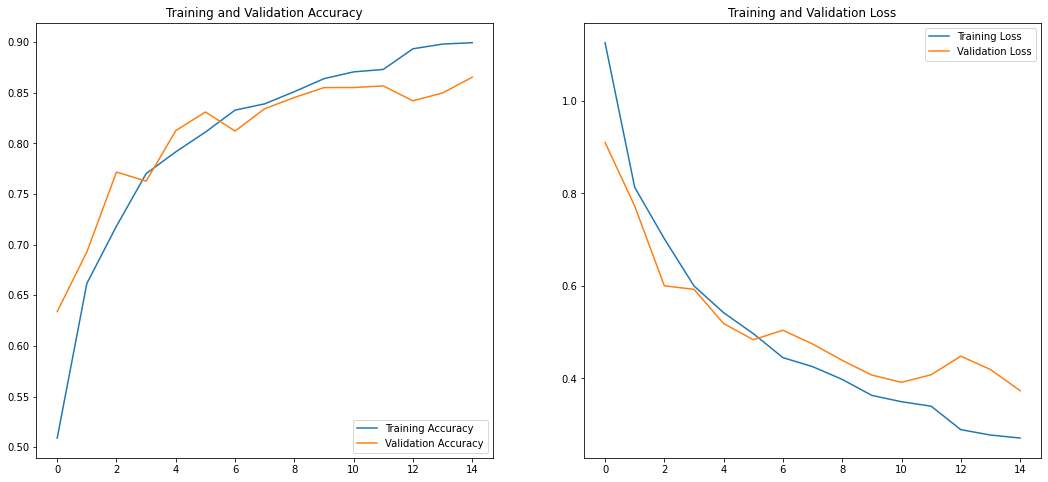

In [30]:
# call the function to plot the curves
plot_loss_accuracy(history, 15)

The model seems well-performed. `Accuracy` on training and validation set looks best fit and it's score increases from around 0.55 to around 0.86 point. While `loss` decreases from around 1.1 point to 0.3 point.

# Model Improvement

For this improvement we will try to use pre-trained model vgg16 to improve our accuracy.

In [31]:
#defining vgg16 model
vgg = VGG16(input_shape = [150,150] + [3], weights = 'imagenet', include_top = False)

#we have to take pre trained weights, we don't want to train the weights again
for layer in vgg.layers:
    layer.trainable = False

#flattening the output of vgg16 for fully connected layer.
x = tf.keras.layers.Flatten()(vgg.output)
normlz = BatchNormalization()(x)
hid_layer = Dense(1024, activation='relu')(normlz)
drpt = Dropout(0.3)(hid_layer)
normlz1 = BatchNormalization()(drpt)
hid_layer1 = Dense(512, activation='relu')(normlz1)
drpt1 = Dropout(0.3)(hid_layer1)
normlz1 = BatchNormalization()(drpt1)
hid_layer2 = Dense(256, activation='relu')(normlz1)

#adding output layer
prediction = tf.keras.layers.Dense(number_classes, activation='softmax')(hid_layer2)

#creating the model and getting the summary
model_imp = tf.keras.models.Model(inputs = vgg.input, outputs = prediction)
model_imp.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

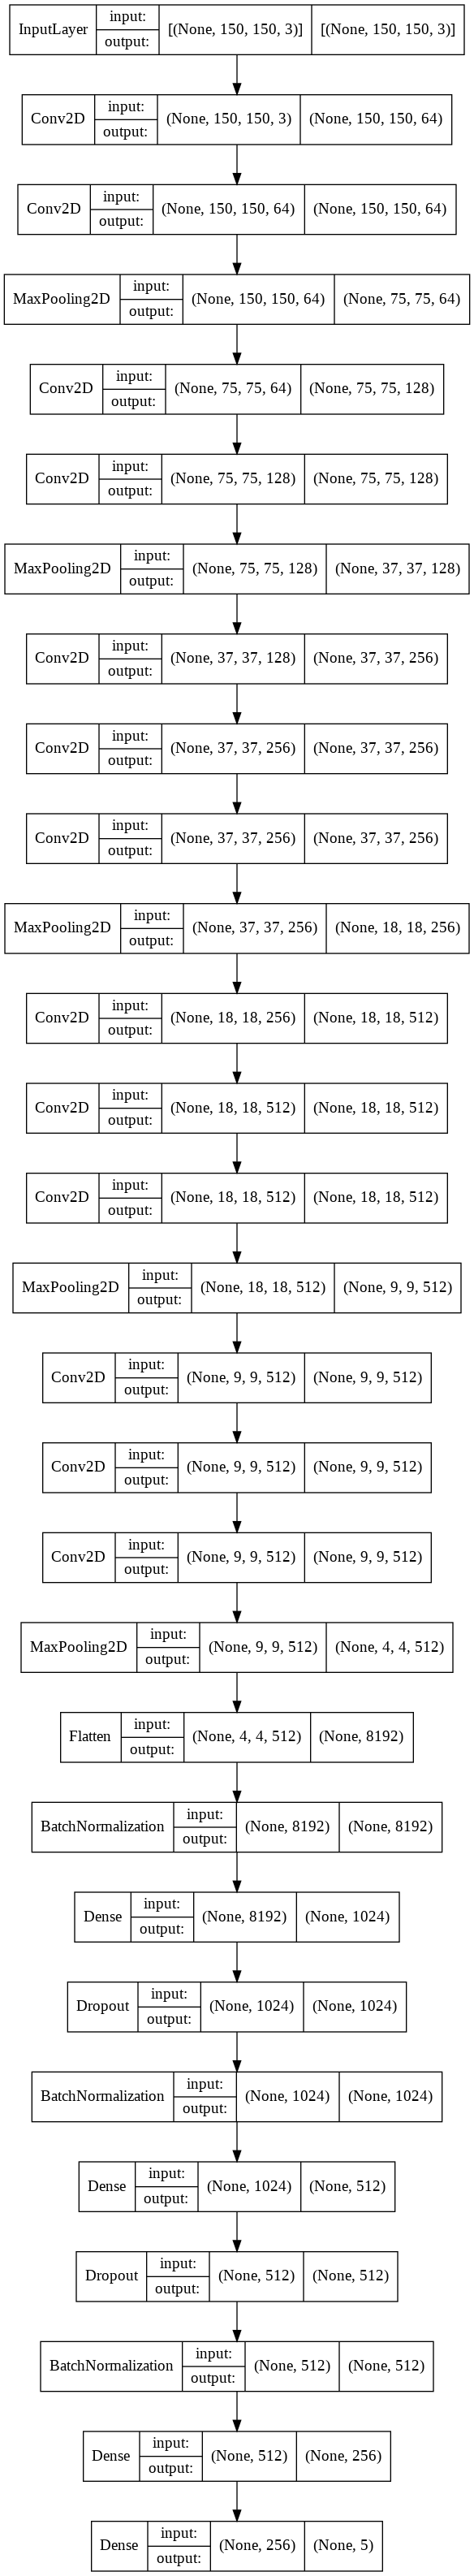

In [32]:
# plot the model algorithm
plot_model(model_imp, show_shapes = True, show_layer_names = False)

In [33]:
#compiling the model
model_imp.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [34]:
#fitting the model with 5 epochs
cnn_vgg = model_imp.fit(train_images_norm, 
                    train_labels_cat, 
                    batch_size = 128, 
                    epochs = 15, 
                    validation_data = (test_images_norm, test_labels_cat),
                    callbacks = callback_list)

Epoch 1/15
91/91 [==============================] - 56s 533ms/step - loss: 0.3424 - accuracy: 0.8747 - val_loss: 0.3183 - val_accuracy: 0.8774
Epoch 2/15
91/91 [==============================] - 41s 452ms/step - loss: 0.1573 - accuracy: 0.9426 - val_loss: 0.2249 - val_accuracy: 0.9187
Epoch 3/15
91/91 [==============================] - 41s 451ms/step - loss: 0.0894 - accuracy: 0.9657 - val_loss: 0.2190 - val_accuracy: 0.9268
Epoch 4/15
91/91 [==============================] - 38s 416ms/step - loss: 0.0662 - accuracy: 0.9749 - val_loss: 0.2755 - val_accuracy: 0.9219
Epoch 5/15
91/91 [==============================] - 37s 412ms/step - loss: 0.0479 - accuracy: 0.9833 - val_loss: 0.2947 - val_accuracy: 0.9264
Epoch 6/15
91/91 [==============================] - 37s 413ms/step - loss: 0.0453 - accuracy: 0.9837 - val_loss: 0.3380 - val_accuracy: 0.9207
Epoch 7/15
91/91 [==============================] - 38s 414ms/step - loss: 0.0408 - accuracy: 0.9858 - val_loss: 0.3819 - val_accuracy: 0.9211

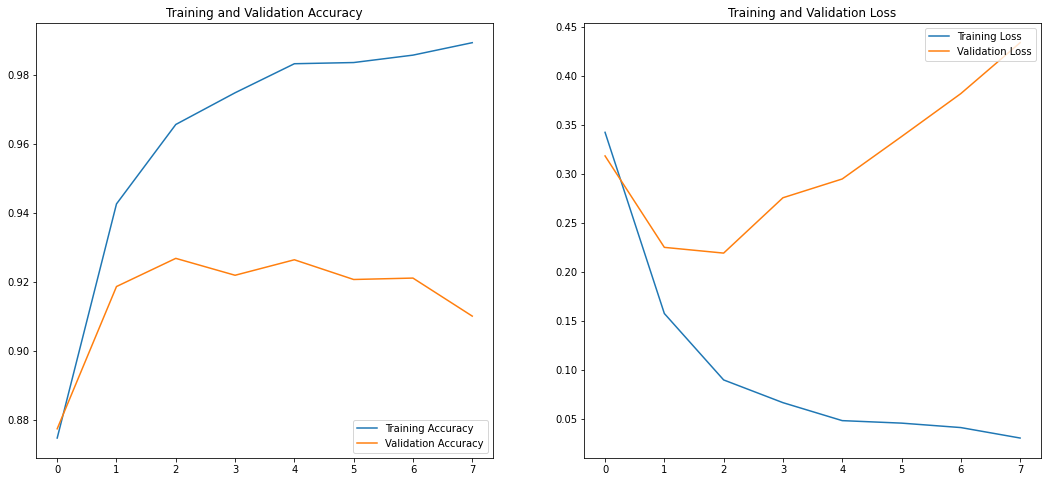

In [35]:
# call the function to plot the curves
plot_loss_accuracy(cnn_vgg, 8)

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 91% in the training process. However, if we set the treshold for overfitting is 10%, then the model not shows overfitting because the difference of training and validation accuracy is only 8%.

Also, the difference in loss between training and validation loss is noticeable—a sign of overfitting.

Does it indicates that base model is better than improved model? Let's have a look on their `error analysis` and `classification report`.

# Model Evalutaion

### *Base Model Error Analysis on Test Data*

In [36]:
# prediction on validation data to check the errors
preds = model.predict(test_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_f = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_f.shape)

Shape of the prediction indexs (2447, 5)
Shape of predicitons vector: (2447,)


In [37]:
test_labels.shape

(2447,)

In [38]:
# convert categorical test labels to numpy array of 1 dim
test_list = []
for i in test_labels_cat:
    index1 = list(np.argwhere(i).reshape(1))[0]
    test_list.append(index1)

test_array = np.array(test_list)
print("shape of actual test array:", test_array.shape)

shape of actual test array: (2447,)


In [39]:
def mislabled_images(class_names, test_images, test_labels, predicted_labels):
    # find the  mislabeled images using np.where and return array of mislabled images
    mislabels = (test_labels == predicted_labels)
    mislabels_index = np.array(np.where(mislabels == False)).ravel()
    mislables_images = test_images[mislabels_index]
    mislables_labels = predicted_labels[mislabels_index]
    
    print("Number of total mislabeled images", mislables_labels.shape)
    
    # plot the 20 mislabeled images
    plt.figure(figsize=(15,9))
    for idx, label in enumerate(mislables_labels[:20]):
        plt.subplot(4,5, idx+1)
        plt.imshow(mislables_images[idx])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Predicted class: {class_names[label]}')   
    
        plt.suptitle(f'Mislabeled images from test data', size=20, weight='bold')
    plt.show()  
    return mislables_labels

Number of total mislabeled images (330,)


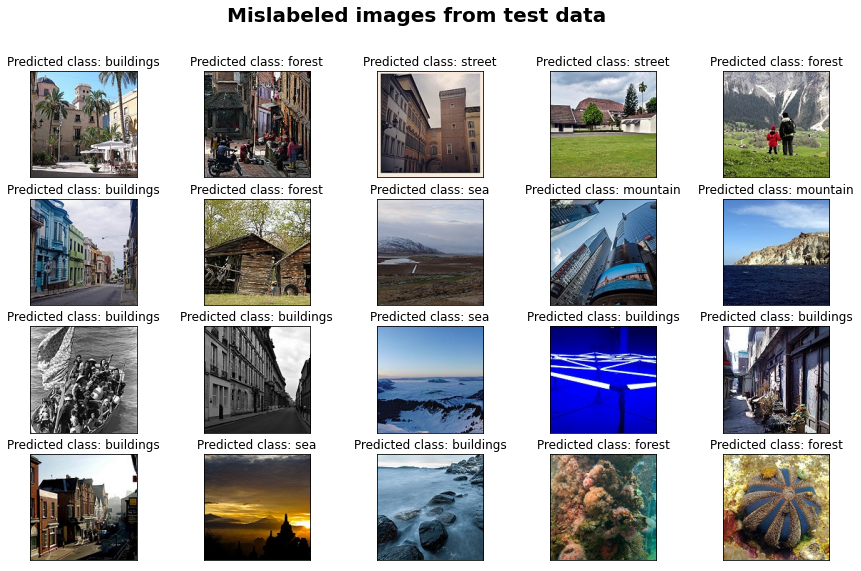

In [40]:
# Mislabeled images from test data
mislables_labels = mislabled_images(class_names, test_images_norm, test_array, predictions_f)

### *Improved Model Error Analysis on Test Data*

In [41]:
# prediction on validation data to check the errors
preds_imp = model_imp.predict(test_images_norm)
print("Shape of the prediction indexs", preds.shape)

# apply argmax function over a rows to find 
predictions_imp = np.argmax(preds, axis=1)
print("Shape of predicitons vector:", predictions_imp.shape)

Shape of the prediction indexs (2447, 5)
Shape of predicitons vector: (2447,)


Number of total mislabeled images (330,)


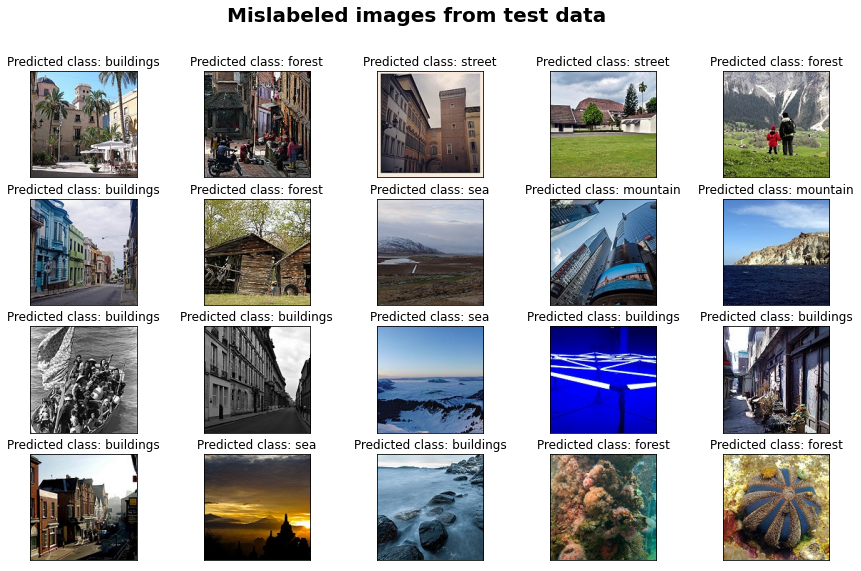

In [42]:
# Mislabeled images from test data
mislables_labels_imp = mislabled_images(class_names, test_images_norm, test_array, predictions_imp)

Notes based on both models error analysis:
- Models confuses between street with buildings and actual building class
- Models confuses sea with mountains and actual mountains. model classifies them as mountains rather than sea

We won't do data augmentation in this problem, as these are the natural scenary images rather than specifics object images

### *Classification Report*

In [43]:
# Predicting
label_pred_train = model.predict(train_images_norm)
label_pred_test = model.predict(test_images_norm)
label_pred_train_imp = model_imp.predict(train_images_norm)
label_pred_test_imp = model_imp.predict(test_images_norm)

In [44]:
#print classification report
print('Base Model Classification Report')
print('-----------train-------------')
print(classification_report(np.array(train_labels_cat).argmax(axis=1), np.array(label_pred_train).argmax(axis=1)))
print('-----------test-------------')
print(classification_report(np.array(test_labels_cat).argmax(axis=1), np.array(label_pred_test).argmax(axis=1)))
print('-'*30)
print('\nImproved Model Classification Report')
print('-----------train-------------')
print(classification_report(np.array(train_labels_cat).argmax(axis=1), np.array(label_pred_train_imp).argmax(axis=1)))
print('-----------test-------------')
print(classification_report(np.array(test_labels_cat).argmax(axis=1), np.array(label_pred_test_imp).argmax(axis=1)))

Base Model Classification Report
-----------train-------------
              precision    recall  f1-score   support

           0       0.92      0.89      0.90      2191
           1       0.91      0.99      0.95      2271
           2       0.93      0.93      0.93      2512
           3       0.91      0.91      0.91      2274
           4       0.94      0.89      0.92      2382

    accuracy                           0.92     11630
   macro avg       0.92      0.92      0.92     11630
weighted avg       0.92      0.92      0.92     11630

-----------test-------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       437
           1       0.90      0.98      0.94       474
           2       0.91      0.91      0.91       525
           3       0.88      0.87      0.87       510
           4       0.83      0.79      0.81       501

    accuracy                           0.87      2447
   macro avg       0.86      0.86      

From this classification report, we will choose the `f1-score` for considering which is the best model since the case of aour project is *classification case*. Actually, we can choose `precission` or `recall` but this time we will choose `f1-score` since the `f1-score` is defined as the harmonic mean between `precision` and `recall`.

As wee can see above, based on `f1-score` on testing set, improved model gives better result than base model. So, we will chose the improved model for data inference.

# Model Inference

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [45]:
# Loading data inference
test_image = r'seg_pred/seg_pred/73.jpg'

img = keras.preprocessing.image.load_img(
    test_image, target_size=(IMAGE_SIZE)
)

In [46]:
# Processing
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Predicting
predictions = model_imp.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to buildings with a 40.46 percent confidence.


# Model Saving

In [47]:
# Save the model in HDF5 format // to use for data inference
model_imp.save("Image_classify_model.h5")

In [48]:
# freeze model
for layer in model_imp.layers:
  layer.trainable = False

# Save model for backend
model_imp.save("Image_classify_model")